# Pendulum
## Description

The inverted pendulum swingup problem is based on the classic problem in control theory.
The system consists of a pendulum attached at one end to a fixed point, and the other end being free.
The pendulum starts in a random position and the goal is to apply torque on the free end to swing it
into an upright position, with its center of gravity right above the fixed point.

The diagram below specifies the coordinate system used for the implementation of the pendulum's
dynamic equations.

![Pendulum Coordinate System](https://gymnasium.farama.org/_images/pendulum.png)

-  `x-y`: cartesian coordinates of the pendulum's end in meters.
- `theta` : angle in radians.
- `tau`: torque in `N m`. Defined as positive _counter-clockwise_.

### Action Space

The action is a `ndarray` with shape `(1,)` representing the torque applied to free end of the pendulum.

| Num | Action | Min  | Max |
|-----|--------|------|-----|
| 0   | Torque | -2.0 | 2.0 |


### Observation Space

The observation is a `ndarray` with shape `(3,)` representing the x-y coordinates of the pendulum's free
end and its angular velocity.

| Num | Observation      | Min  | Max |
|-----|------------------|------|-----|
| 0   | x = cos(theta)   | -1.0 | 1.0 |
| 1   | y = sin(theta)   | -1.0 | 1.0 |
| 2   | Angular Velocity | -8.0 | 8.0 |

### Rewards

The reward function is defined as:

*r = -(theta<sup>2</sup> + 0.1 * theta_dt<sup>2</sup> + 0.001 * torque<sup>2</sup>)*

where `$\theta$` is the pendulum's angle normalized between *[-pi, pi]* (with 0 being in the upright position).
Based on the above equation, the minimum reward that can be obtained is
*-(pi<sup>2</sup> + 0.1 * 8<sup>2</sup> + 0.001 * 2<sup>2</sup>) = -16.2736044*,
while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

### Starting State

The starting state is a random angle in *[-pi, pi]* and a random angular velocity in *[-1,1]*.

### Episode Truncation

The episode truncates at 200 time steps.

### Arguments

- `g`: acceleration of gravity measured in *(m s<sup>-2</sup>)* used to calculate the pendulum dynamics.
    The default value is g = 10.0 .

```python
import gymnasium as gym
gym.make('Pendulum-v1', g=9.81)
```

On reset, the `options` parameter allows the user to change the bounds used to determine
the new random state.

### Version History

* v1: Simplify the math equations, no difference in behavior.
* v0: Initial versions release (1.0.0)


## Import Env

In [1]:
import gymnasium as gym
from gymnasium.envs.classic_control.pendulum import PendulumEnv

for k,v in gym.envs.registry.items():
    print(str(k)+"\t"+str(v))

CartPole-v0	EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
CartPole-v1	EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
MountainCar-v0	EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.

In [2]:
env = gym.make("Pendulum-v1")
print("Observation space", env.observation_space)
print("Action space", env.action_space)

Observation space Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action space Box(-2.0, 2.0, (1,), float32)


## DQN
### State Normalization

In [3]:
import numpy as np


def normalizer(env: gym.Env, state: np.ndarray):
    LOW = env.observation_space.low
    HIGH = env.observation_space.high
    normalized_state = np.zeros(state.shape)
    normalized_state = (state-LOW)/(HIGH - LOW)
    return normalized_state

normalizer(env,env.reset()[0])

array([0.7692542 , 0.07868996, 0.5251672 ], dtype=float32)

### Action Space Discretization

In [4]:
class Action:
    def __init__(self, env: gym.Env, num_actions: int = 21) -> None:
        self.action = np.linspace(env.action_space.low, env.action_space.high, num_actions)

    def get_action(self, index: int) -> float:
        return self.action[index]

    def get_num_actions(self) -> int:
        return len(self.action)

### Experience

In [5]:
from collections import namedtuple, deque
import random
Transaction = namedtuple("Transaction", ["state", "action", "next_state", "next_action", "reward"])


class Experience:
    def __init__(self, maxlen: int) -> None:
        self.experience = deque([], maxlen)

    def append(self, transaction: Transaction) -> None:
        self.experience.append(transaction)

    def sample(self, batch_size: int) -> None:
        return random.sample(self.experience, batch_size)

    def __len__(self) -> int:
        return len(self.experience)

### Q network

In [6]:
import torch.nn as nn
import torch


class DQN(nn.Module):
    def __init__(self, num_observations, num_actions) -> None:
        super().__init__()
        self.num_hidden = 128
        self.linear_1 = nn.Linear(num_observations, self.num_hidden)
        self.linear_2 = nn.Linear(self.num_hidden, self.num_hidden)
        self.linear_3 = nn.Linear(self.num_hidden, num_actions)
        self.selu = nn.SELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_1(x)
        x = self.selu(x)
        x = self.linear_2(x)
        x = self.selu(x)
        x = self.linear_3(x)
        return x

### Epsilon-Greedy

In [7]:
def get_epsilon(epsilon_start: float, epsilon_end: float, step: int, epsilon_decay: int = 500):
    return epsilon_end+(epsilon_start-epsilon_end)*np.exp(-1.0*step/epsilon_decay)


def epsilon_greedy(q_approximator: nn.Module, state: torch.Tensor, epsilon: float, num_actions: int) -> int:
    q_actions = q_approximator(state).detach().cpu().numpy()
    probability = np.ones(num_actions)*epsilon/num_actions
    index_action_with_max_q = np.argmax(q_actions)
    probability[index_action_with_max_q] = 1-np.sum(probability[1:])
    return np.random.choice(np.arange(num_actions), p=probability)

### Learning Rate Decay

In [8]:
def get_learning_rate(learning_rate_start: float, learning_rate_end: float, step: int, learning_rate_decay: int = 1000):
    return learning_rate_end+(learning_rate_start-learning_rate_end)*np.exp(-1.0*step/learning_rate_decay)

### Q Learning

In [9]:
def q_learning_update_policy_net(policy_net: DQN, target_net: DQN, experience: Experience, batch_size: int, gamma: float, learning_rate: float, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, tau: float, device: str):
    for g in optimizer.param_groups:
        g["lr"] = learning_rate

    batch = experience.sample(batch_size)
    batch_state, batch_action, batch_next_state, batch_next_action, batch_reward = zip(*batch)

    mask_batch_next_state_is_not_none = [next_state is not None for next_state in batch_next_state]
    batch_not_none_next_state = [next_state for next_state in batch_next_state if next_state is not None]

    batch_state = torch.tensor(batch_state, dtype=torch.float32, device=device)
    batch_action = torch.tensor(batch_action, dtype=torch.int64, device=device).reshape((-1, 1))
    batch_not_none_next_state = torch.tensor(batch_not_none_next_state, dtype=torch.float32, device=device)
    batch_reward = torch.tensor(batch_reward, dtype=torch.float32, device=device).reshape((-1, 1))
    mask_batch_next_state_is_not_none = torch.tensor(mask_batch_next_state_is_not_none, dtype=torch.bool, device=device)

    q_state_action = policy_net(batch_state).gather(1, batch_action)
    q_next_state_action = torch.zeros(q_state_action.size(), device=device)
    with torch.no_grad():
        batch_max_action = policy_net(batch_not_none_next_state).max(1)[1].reshape((-1, 1))
        q_next_state_action[mask_batch_next_state_is_not_none] = target_net(batch_not_none_next_state).gather(1, batch_max_action)
    q_target = batch_reward+gamma*q_next_state_action

    optimizer.zero_grad()
    loss = loss_fn(q_state_action, q_target)
    loss.backward()
    optimizer.step()

    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key]*(1-tau)
    target_net.load_state_dict(target_net_state_dict)

    return loss.item()

In [10]:
from collections import defaultdict


def q_learning(env: gym.Env, num_episodes: int = 1000, experience_maxlen=2**10, batch_size=64,
               gamma: float = 0.9,
               learning_rate_start: float = 1e-3, learning_rate_end: float = 1e-4,
               epsilon_start: float = 0.9, epsilon_end: float = 0.05,
               tau=0.005,
               device: str = "cpu",
               print_step: int = 100):
    action_candidates = Action(env)

    policy_net = DQN(env.observation_space.shape[0], action_candidates.get_num_actions()).to(device)
    target_net = DQN(env.observation_space.shape[0], action_candidates.get_num_actions()).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    loss_fn = nn.SmoothL1Loss()
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=learning_rate_start)

    experience = Experience(experience_maxlen)

    num_attempts_per_episode = defaultdict(int)
    reward_per_episode = defaultdict(float)

    loss = 0.0

    for episode_i in range(num_episodes):
        state = env.reset()[0]
        is_truncated = False

        epsilon = get_epsilon(epsilon_start, epsilon_end, episode_i, num_episodes)
        learning_rate = get_learning_rate(learning_rate_start, learning_rate_end, episode_i, num_episodes)

        while not is_truncated:
            normalized_state = normalizer(env, state)
            normalized_state_tensor = torch.tensor(normalized_state, dtype=torch.float32, device=device)
            action_index = epsilon_greedy(policy_net, normalized_state_tensor, epsilon, action_candidates.get_num_actions())
            action = action_candidates.get_action(action_index)
            next_state, reward, is_terminated, is_truncated, info = env.step(action)
            normalized_next_state = normalizer(env, next_state)
            if is_truncated:
                next_state = None
                normalized_next_state = None

            experience.append(Transaction(normalized_state, action_index, normalized_next_state, None, reward))

            state = next_state

            if len(experience) > batch_size:
                loss = q_learning_update_policy_net(policy_net, target_net, experience, batch_size, gamma, learning_rate, loss_fn, optimizer, tau, device)

            num_attempts_per_episode[episode_i] += 1
            reward_per_episode[episode_i] += reward

        if episode_i % print_step == 0:
            print("episode %d, loss %f, num_attempts %d, reward %d" % (episode_i, loss, num_attempts_per_episode[episode_i], reward_per_episode[episode_i]))

    return policy_net, num_attempts_per_episode, reward_per_episode

In [12]:
import time
t_start=time.time()
q_learning_policy_net,q_learning_num_attempts_per_episode,q_learning_reward_per_episode=q_learning(env,num_episodes=1500,experience_maxlen=2**10,batch_size=128,gamma=0.9,learning_rate_start=1e-3,learning_rate_end=1e-4,epsilon_start=0.1,epsilon_end=0.05,tau=0.005,device="cuda" if torch.cuda.is_available() else "cpu",print_step=100)
t_end=time.time()
print("training cost: ", t_end-t_start)

KeyboardInterrupt: 

### Plot Train Result

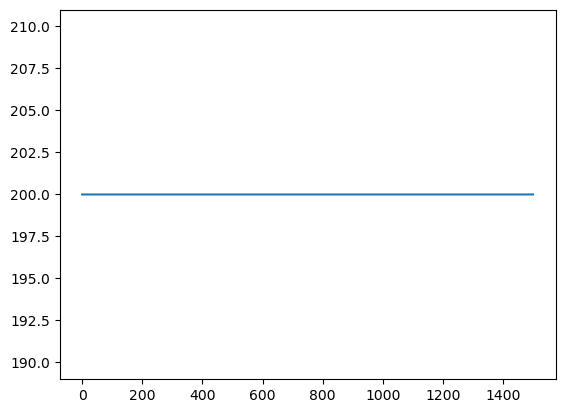

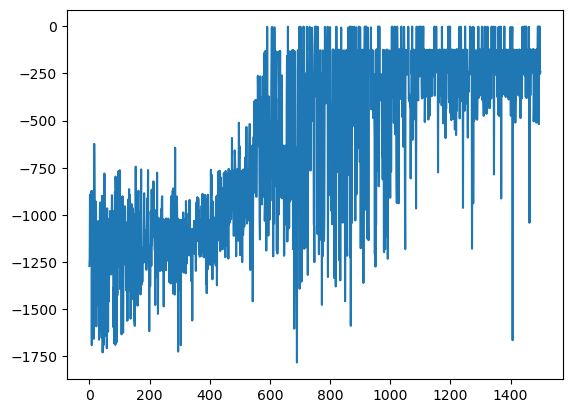

In [ ]:
import matplotlib.pyplot as plt
from typing import Dict
def plot_num_attempts_per_episode(num_attempts_per_episode:Dict):
    fig,ax=plt.subplots()
    ax.plot(num_attempts_per_episode.keys(),num_attempts_per_episode.values())
    
def plot_reward_per_episode(reward_per_episode:Dict):
    fig,ax=plt.subplots()
    ax.plot(reward_per_episode.keys(),reward_per_episode.values())
    
plot_num_attempts_per_episode(q_learning_num_attempts_per_episode)
plot_reward_per_episode(q_learning_reward_per_episode)